## Connect To Drive

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
root = "drive/MyDrive/ANNSSM/codes/Datasets"

## Importing Packages

In [23]:
import numpy as np
import pickle
import csv
from tqdm import tqdm
import pandas as pd
import tensorflow as tf

## Data Preparation

#### Load SUBTLEX data

In [24]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root + '/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [25]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] >= 4:
        category = 'HF'
    else:
        category = 'LF'
    return category

# Load ELP data and Merge with Subtlex data

Reading **words** and **non-words** datasets



In [26]:
words = []
with open(root+"/Items.csv", 'r') as file:
    reader = csv.reader(file)
    for index, row in enumerate(tqdm(reader)):
        if index == 0:
            continue
        words.append([row[0], row[2].replace(',', ''), 'word'])


nonwords = []
with open(root+"/nonword.csv", 'r') as file:
    reader = csv.reader(file)
    for index, row in enumerate(tqdm(reader)):
        if index == 0:
            continue
        nonwords.append([row[0], 'nonword'])


40483it [00:00, 489428.76it/s]
40342it [00:00, 198294.65it/s]


Adding appropriate encodings for extra information for both words and non-words

In [27]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

In [28]:
data_df = pd.DataFrame(words + nonwords,
               columns =['string', 'freq', 'type', 'code', 'label'])

In [29]:
data_df

,string,freq,type,code,label
0,a,10610626,word,"[1, 0]",1
1,aah,222,word,"[1, 0]",1
2,Aaron,10806,word,"[1, 0]",1
3,aback,387,word,"[1, 0]",1
4,abacus,513,word,"[1, 0]",1
...,...,...,...,...,...
80818,declassificarion,0,nonword,"[0, 1]",0
80819,antifundamentadast,0,nonword,"[0, 1]",0
80820,transcontanental,0,nonword,"[0, 1]",0
80821,iv,0,nonword,"[0, 1]",0


Loading elp data and merging them with subtlex data

In [30]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
elp_df = pd.concat([elp_words, elp_nonwords])

# 
elp_df.fillna(0, inplace=True)
elp_df['category'] = elp_df.apply(lambda row: categorise_by_zipf(row), axis=1)
elp_df.drop_duplicates(subset=['string'], inplace=True)

In [31]:
elp_df = elp_df.sample(frac=1.0)
elp_df.head()

,string,freq,represention,code,label,zipf,category
32511,simples,141,word,"[1, 0]",1,1.592864,LF
32566,fluggish,0,nonword,"[0, 1]",0,0.000000,NW
17378,iddustrious,0,nonword,"[0, 1]",0,0.000000,NW
25521,paste,6656,word,"[1, 0]",1,3.236317,LF
14758,furtively,76,word,"[1, 0]",1,1.768955,LF


Splitting train and test datasets

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(elp_df['string'],elp_df['label'], stratify=elp_df['label'])

In [34]:
y_train

34899    1
2022     0
16403    0
16146    0
4819     1
        ..
5482     0
25086    0
35925    1
22332    1
281      1
Name: label, Length: 55737, dtype: int64

Add encodings for train and test outputs representing the correct labels of each entry in the dataset

In [35]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [36]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Building the Model

In [37]:
!pip install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 28.1 MB/s 


In [38]:
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing', trainable=False)

encoder_inputs = preprocessing_layer(text_input)
#version1: small bert
# encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", name='BERT_encoder', trainable=False)

#version2: bert_en_uncased_L-12_H-768_A-12
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", name='BERT_encoder', trainable=False)

outputs = encoder(encoder_inputs)

# Neural network layers
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(300, activation="relu", name="dense1")(net)
net = tf.keras.layers.Dense(300, activation="relu", name="dense2")(net)
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(100, activation="relu", name="dense3")(net)
net = tf.keras.layers.Dense(50, activation="relu", name="dense4")(net)
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [net])

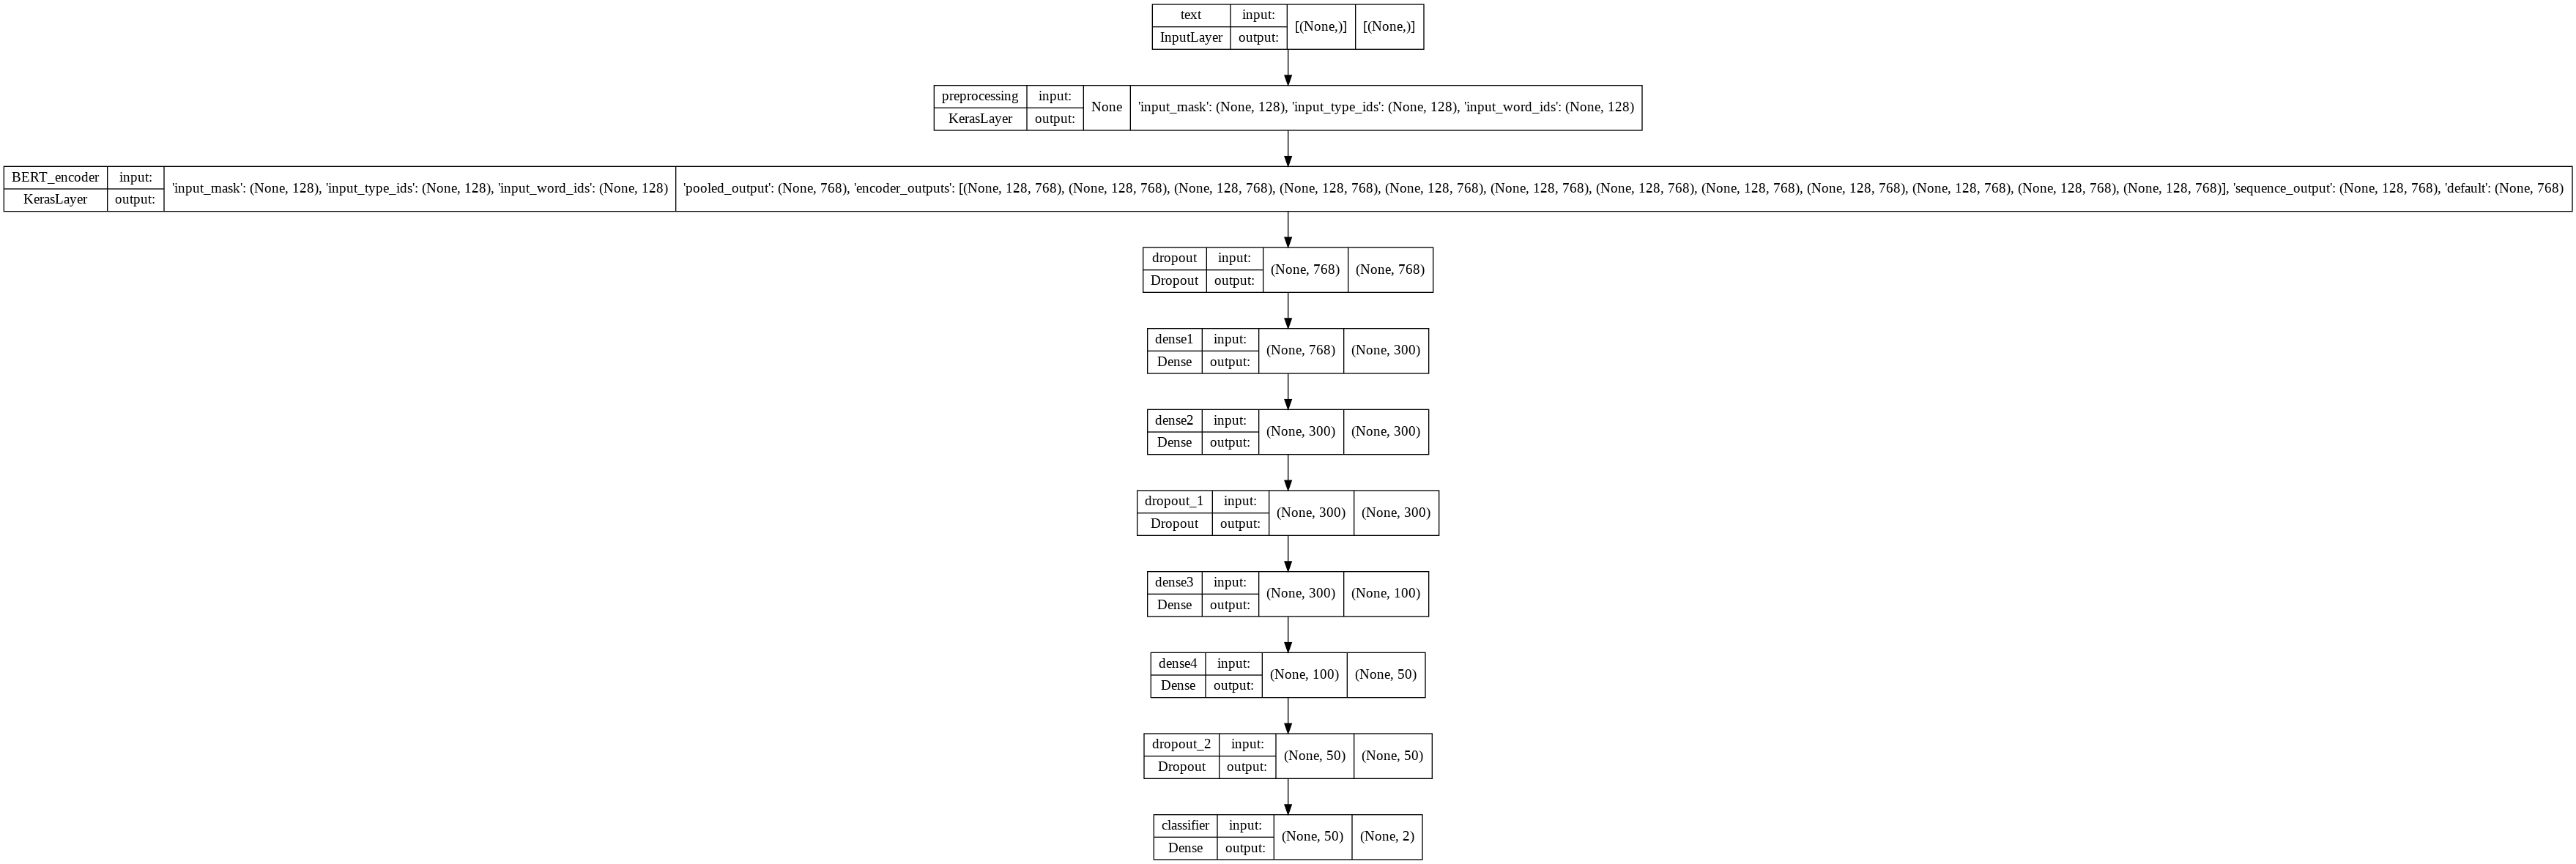

In [ ]:
tf.keras.utils.plot_model(model, to_file='drive/MyDrive/ANNSSM/codes/BERT-RDM/BERT_model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size = 64,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=3,
          restore_best_weights=True
      )
  ]
)

Epoch 1/10
871/871 [==============================] - 838s 950ms/step - loss: 0.4087 - accuracy: 0.8136 - val_loss: 0.3782 - val_accuracy: 0.8250
Epoch 2/10
871/871 [==============================] - 824s 947ms/step - loss: 0.3413 - accuracy: 0.8549 - val_loss: 0.3036 - val_accuracy: 0.8717
Epoch 3/10
871/871 [==============================] - 824s 946ms/step - loss: 0.3302 - accuracy: 0.8608 - val_loss: 0.2869 - val_accuracy: 0.8866
Epoch 4/10
871/871 [==============================] - 829s 953ms/step - loss: 0.3218 - accuracy: 0.8655 - val_loss: 0.2769 - val_accuracy: 0.8910
Epoch 5/10
871/871 [==============================] - 835s 959ms/step - loss: 0.3189 - accuracy: 0.8661 - val_loss: 0.2772 - val_accuracy: 0.8870
Epoch 6/10
871/871 [==============================] - 832s 955ms/step - loss: 0.3219 - accuracy: 0.8643 - val_loss: 0.3010 - val_accuracy: 0.8779
Epoch 7/10
871/871 [==============================] - 832s 955ms/step - loss: 0.3121 - accuracy: 0.8684 - val_loss: 0.3041 -

Saving the model

In [ ]:
model.save("drive/MyDrive/ANNSSM/codes/BERT-RDM/BERT_model")

INFO:tensorflow:Assets written to: drive/MyDrive/ANNSSM/codes/BERT-RDM/BERT_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/ANNSSM/codes/BERT-RDM/BERT_model/assets


## Predicted Probabilities on full dataset

In [48]:
from sklearn import metrics

full_dataset_predictions = model.predict(np.array(elp_df['string']))

#### Classification results

In [49]:
print(metrics.classification_report(elp_df['label'].to_numpy(),  np.argmax(full_dataset_predictions, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.8955    0.9028    0.8991     40339
           1     0.8835    0.8749    0.8792     33978

    accuracy                         0.8901     74317
   macro avg     0.8895    0.8889    0.8892     74317
weighted avg     0.8900    0.8901    0.8900     74317



In [51]:
acc_score = (metrics.accuracy_score(elp_df['label'].to_numpy(),  np.argmax(full_dataset_predictions, axis=1)))
acc_score

0.890052074222587

#### Confusion Matrix

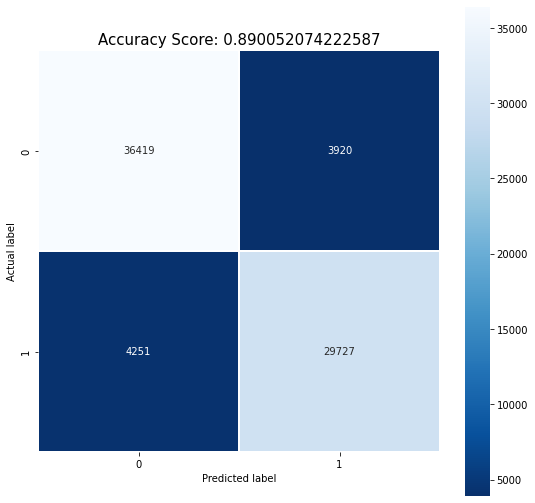

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

test_predictions = model.predict(X_test)
cm = metrics.confusion_matrix(elp_df['label'].to_numpy(), np.argmax(full_dataset_predictions, axis=1))
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 15);
plt.savefig('drive/MyDrive/ANNSSM/codes/BERT_ACC')

#### Pridected Probabilites for each words category and non-words

In [54]:
elp_df['word_prob']=full_dataset_predictions[:,1]
elp_df['nword_prob']=full_dataset_predictions[:,0]

In [55]:
elp_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                      nword_prob            \
              mean       std  count       max       min       mean       std   
category                                                                       
HF        0.906982  0.124677   3879  0.999876  0.069634   0.093018  0.124677   
LF        0.778553  0.242725  30099  0.999999  0.003574   0.221447  0.242725   
NW        0.155189  0.210682  40339  0.999999  0.000449   0.844811  0.210682   

                                     
          count       max       min  
category                             
HF         3879  0.930366  0.000124  
LF        30099  0.996426  0.000001  
NW        40339  0.999551  0.000001

## Save Predicted Probabilities of full dataset

In [56]:
word_df_to_save = elp_df.drop(['represention', 'code'], axis=1)

In [57]:
word_df_to_save

,string,freq,label,zipf,category,word_prob,nword_prob
32511,simples,141,1,1.592864,LF,0.386628,0.613372
32566,fluggish,0,0,0.000000,NW,0.652770,0.347230
17378,iddustrious,0,0,0.000000,NW,0.034733,0.965267
25521,paste,6656,1,3.236317,LF,0.974957,0.025043
14758,furtively,76,1,1.768955,LF,0.541270,0.458730
...,...,...,...,...,...,...,...
25274,rattered,0,0,0.000000,NW,0.650757,0.349243
20958,madrogals,0,0,0.000000,NW,0.256779,0.743221
38446,derandas,0,0,0.000000,NW,0.007479,0.992521
27084,pressuraze,0,0,0.000000,NW,0.401949,0.598051


In [58]:
word_df_to_save.to_csv(root+"/BERT.csv", header=0, index=False)